**DATASET DOWNLOAD FROM KAGGLE**

1. Go to your kaggle account, Scroll to API section and Click Expire API Token to remove previous tokens.  
2. Click on Create New API Token - It will download kaggle.json file on your machine.
3. Run the following commands(Choose the kaggle.json file that you downloaded).

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tipsijadav/covid19-ct
! unzip \*.zip

**IMPORTING NECESSARY LIBRARIES**

In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D

In [6]:
tf.config.run_functions_eagerly(True)

**DEFINING PATH TO DATASET**

In [7]:
image_path = '/content/ct_scans'
mask_path = '/content/lung_mask'

**DATA EXTRCATION AND PRE-PROCESSING**

In [8]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return(array)

In [9]:
image_path_list = os.listdir(image_path)

images = []
masks = []
for row in image_path_list:
    image_path1 = os.path.join(image_path, row)
    mask_path1 = os.path.join(mask_path, row)

    image_read = read_nii(image_path1)
    mask_read = read_nii(mask_path1) 
    
    image_final = cv2.resize(image_read, (128, 128))        
    mask_final = cv2.resize(mask_read, (128, 128))
        
    for i in range(image_final.shape[2]):
        temp_image = np.expand_dims(image_final[...,i], axis=-1)
    
        images.append(temp_image)
        masks.append(mask_final[...,i])

In [10]:
images = np.array(images)
images = images/((images.max()) - (images.min()))

In [11]:
masks = np.array(masks, dtype='int64')
masks  = tf.one_hot(masks, 3, dtype='float64', axis=-1).numpy()

**TRAIN/VALIDATION/TEST SPLIT**

In [12]:
x_train, test_images, y_train, test_masks = train_test_split(images, masks, test_size=0.2, random_state=0)

In [13]:
train_images, valid_images, train_masks, valid_masks = train_test_split(x_train, y_train, test_size=0.25, random_state=0)

**CONVOLUTION BLOCKS**

In [14]:
#down sampling
def down_samp(x, filters):
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(x)
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    
    return c, p
    
#bottleneck 
def bottlenock(x, filters):
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(x)
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(c)
    
    return c
    
#up sampling
def up_samp(x, skip, filters):
    us = UpSampling2D((2, 2))(x)
    conc = Concatenate()([us, skip])
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(conc)
    c = Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu", kernel_initializer='he_normal')(c)
    
    return c

**UNET ARCHITECTURE**

In [19]:
def unet():
    f = [8, 16, 32]
    
    inputs = Input((128, 128, 1))
    
    c1, p1 = down_samp(inputs, f[0])
    c2, p2 = down_samp(p1, f[1])
    
    bn = bottlenock(p2, f[2])
    
    d1 = up_samp(bn, c2, f[1])
    d2 = up_samp(d1, c1, f[0])
 
    outputs = Conv2D(3, (1, 1), padding="same", activation="softmax")(d2)
  
    model = Model(inputs, outputs)
    
    return model

In [20]:
def dice_coefficient(y_true, y_pred):

  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])

  dice_coef = K.mean((2. * intersection)/union, axis=0)
  
  return dice_coef

In [21]:
model = unet()
model.compile(optimizer='adam', 
              loss = 'categorical_crossentropy',
              metrics = [dice_coefficient])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 8)  584         conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_12[0][0]                  
____________________________________________________________________________________________

**TRAINING THE MODEL**

In [22]:
history = model.fit(train_images,
                    train_masks,
                    epochs=18,
                    validation_data=(valid_images, valid_masks))

Epoch 1/18
66/66 [==============================] - 152s 2s/step - loss: 0.5025 - dice_coefficient: 0.7361 - val_loss: 0.2967 - val_dice_coefficient: 0.8675
Epoch 2/18
66/66 [==============================] - 160s 2s/step - loss: 0.2096 - dice_coefficient: 0.8880 - val_loss: 0.1677 - val_dice_coefficient: 0.9026
Epoch 3/18
66/66 [==============================] - 160s 2s/step - loss: 0.1369 - dice_coefficient: 0.9214 - val_loss: 0.1302 - val_dice_coefficient: 0.9213
Epoch 4/18
66/66 [==============================] - 150s 2s/step - loss: 0.1097 - dice_coefficient: 0.9338 - val_loss: 0.1103 - val_dice_coefficient: 0.9322
Epoch 5/18
66/66 [==============================] - 160s 2s/step - loss: 0.1046 - dice_coefficient: 0.9364 - val_loss: 0.1039 - val_dice_coefficient: 0.9352
Epoch 6/18
66/66 [==============================] - 160s 2s/step - loss: 0.0909 - dice_coefficient: 0.9438 - val_loss: 0.0920 - val_dice_coefficient: 0.9458
Epoch 7/18
66/66 [==============================] - 160s 2

**DICE COEFFICIENT AND LOSS PLOT**

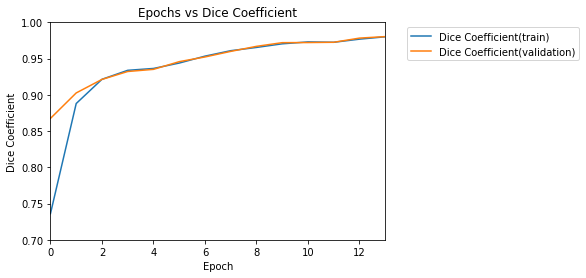

In [23]:
plt.plot(history.history['dice_coefficient'], label='Dice Coefficient(train)')
plt.plot(history.history['val_dice_coefficient'], label = 'Dice Coefficient(validation)')
plt.xlim([0, 13])
plt.ylim([0.7, 1])
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Epochs vs Dice Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

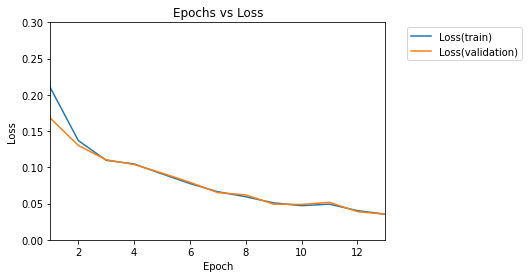

In [24]:
plt.plot(history.history['loss'], label='Loss(train)')
plt.plot(history.history['val_loss'], label = 'Loss(validation)')
plt.xlim([1, 13])
plt.ylim([0.0, 0.3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**EVALUATION ON TEST DATA-SET**

In [25]:
evalu = model.evaluate(test_images, test_masks, verbose=0)
print('The Dice Coefficient of model on Test Data-Set is = '"{:.2f}".format(evalu[1]*100), '%')

The Dice Coefficient of model on Test Data-Set is = 98.42 %
